In [1]:
import tensorflow as tf
import numpy as np
from scipy.fft import dctn
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

2024-11-11 15:05:38.853506: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 15:05:38.984720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 15:05:39.036315: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 15:05:39.051254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 15:05:39.151788: I tensorflow/core/platform/cpu_feature_guar

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
N = 5  # Adjust this as needed

def random_seeds_generator(N):
    return  np.random.choice(np.arange(0, 2**16 - 1), size=N, replace=False)

def select_images(train_images, train_labels, N, seed):
    np.random.seed(seed)
    train_labels = train_labels.flatten()
    unique_selections = []
    for _ in range(N):
        selected_set = []
        used_indices = set()
        for label in range(10):
            label_indices = np.where(train_labels == label)[0]
            available_indices = list(set(label_indices) - used_indices)
            chosen_index = np.random.choice(available_indices)
            selected_set.append((train_images[chosen_index], train_labels[chosen_index]))
            used_indices.add(chosen_index)
        unique_selections.append(selected_set)
    all_images = []  # List to store images from each set
    all_labels = []  # List to store labels from each set

    for selected_set in unique_selections:
        images = [item[0] for item in selected_set]  # Extract images
        labels = [item[1] for item in selected_set]  # Extract labels
        all_images.append(images)
        all_labels.append(labels)
    return all_images, all_labels


In [5]:
random_seeds_generator(N)

array([46051, 46114, 11615, 45757,  9866])

In [6]:
all_images, all_labels = select_images(train_images, train_labels, 5, seed=random_seeds_generator(N)[0])

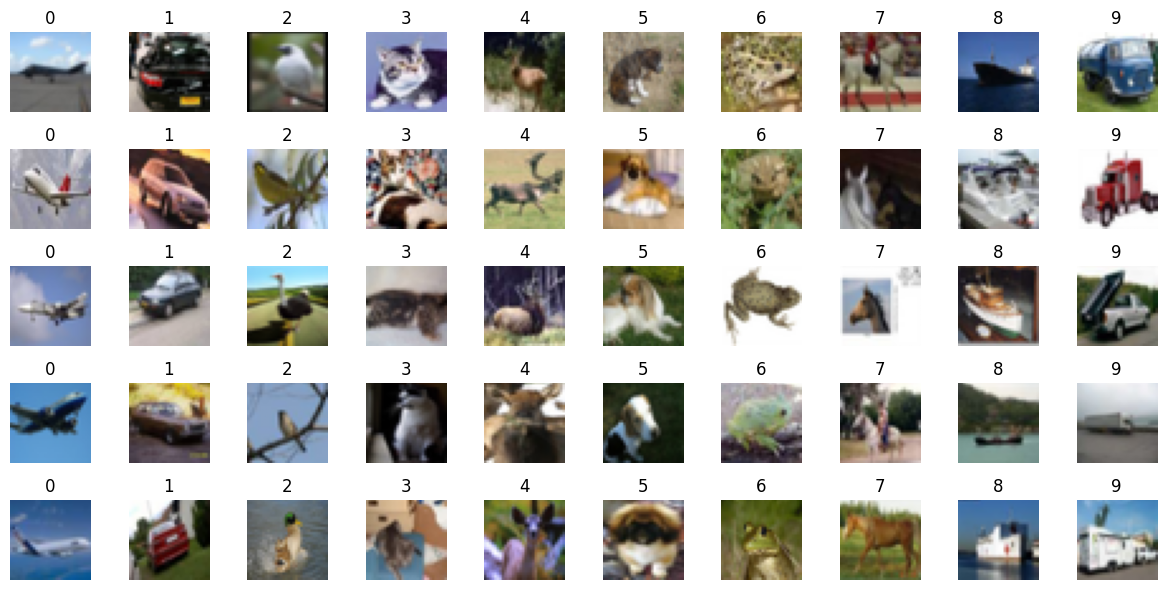

In [7]:
import matplotlib.pyplot as plt

def visualize_images(images, labels, rows, cols):
    """
    Visualize a set of images with their corresponding labels.
    
    Parameters:
    - images: List of lists containing image data (e.g., numpy arrays).
    - labels: List of lists containing labels corresponding to the images.
    - rows: Number of rows to display in the grid.
    - cols: Number of columns to display in the grid.
    """
    # Flatten the lists if needed (if images and labels are nested lists)
    flat_images = [img for sublist in images for img in sublist]
    flat_labels = [label for sublist in labels for label in sublist]
    
    # Set up the figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(flat_images):
            ax.imshow(flat_images[i], cmap='gray')  # Use 'gray' if the images are grayscale
            ax.set_title(flat_labels[i])
            ax.axis('off')  # Hide axes
        else:
            ax.axis('off')  # Hide empty subplots
    
    plt.tight_layout()
    plt.show()

# Example usage:
# images = [[img1, img2], [img3, img4]]  # Replace with your actual image data
# labels = [['cat', 'dog'], ['bird', 'fish']]
# visualize_images(images, labels)
visualize_images(all_images, all_labels, rows=5, cols=10)


In [8]:
all_labels[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
def build_original_model():
        model = Sequential([
                Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
                Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
                MaxPooling2D((2,2), name='pool1'),
                Dropout(0.25),

                Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
                Conv2D(128, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
                MaxPooling2D((2,2), name='pool2'),
                Dropout(0.25),

                Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
                Conv2D(256, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
                MaxPooling2D((2,2), name='pool3'),
                Dropout(0.25),

                Conv2D(512, (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
                MaxPooling2D((2,2), name='pool4'),
                Dropout(0.25),
                #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
                Flatten(name='flatten'),
                Dense(256, activation='relu',kernel_initializer='he_normal', name='fc1'),
                Dense(128, activation='relu',kernel_initializer='he_normal', name='fc2'),
                Dense(64, activation='relu',kernel_initializer='he_normal', name='fc3'),
                Dense(10, activation='softmax', name='output')
                ])
        return model
model = build_original_model()

/home/am/Documents/VirtualEnv/tensorflow_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731305143.673002   73882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731305143.771660   73882 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:173130514

In [11]:
model_copies = [tf.keras.models.clone_model(model) for _ in range(N)]

In [12]:
for i in range(N):
    model_copies[i].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model_copies[i].fit(np.array(all_images[i]), np.array(all_labels[i]), epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


I0000 00:00:1731305146.091226   74138 service.cc:146] XLA service 0x778a0c0032c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731305146.091242   74138 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-11 15:05:46.134493: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-11 15:05:46.360157: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0000e+00 - loss: 4.3308

I0000 00:00:1731305150.695564   74138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0000e+00 - loss: 4.3308 - val_accuracy: 0.0000e+00 - val_loss: 2.7222
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0000e+00 - loss: 2.8238 - val_accuracy: 0.0000e+00 - val_loss: 2.9040
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 2.4853 - val_accuracy: 0.0000e+00 - val_loss: 2.9882
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 2.3133 - val_accuracy: 0.0000e+00 - val_loss: 3.0617
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 2.0501 - val_accuracy: 0.0000e+00 - val_loss: 3.3737
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1250 - loss: 2.3449 - val_accuracy: 0.0000e+00 - val_loss: 3.6242
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1250 - loss: 2.3803 - val_accuracy: 0.0000e+00 - val_loss: 3.7555
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3750 - loss: 1.8902 - val_accuracy: 0.0

In [13]:

def get_filters(model, layer_name, filter_indices):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    return filters[:, :, :, filter_indices]


def get_all_filters(model, layer_name):
    layer = model.get_layer(name=layer_name)
    filters, biases = layer.get_weights()
    return filters

In [14]:
def properties(model, layer_name, property_name):
    filter_norms = []
    filter_correlation = []
    feature_map_correlation = []
    feature_map_dct = []

    layer = model.get_layer(layer_name)
    filters, biases = layer.get_weights()
    num_filters = filters.shape[-1]

    if property_name == 'filter_norm':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            norm = np.linalg.norm(filt_matrix)
            filter_norms.append(norm)
        return filter_norms
    
    elif property_name == 'filter_correlation':
        for i in range(num_filters):
            filt = filters[:, :, :, i]
            filt_matrix = filt.reshape(-1, filt.shape[-1])
            uniqueness = np.linalg.norm(filt_matrix) - np.linalg.norm(get_all_filters(model, layer_name))
            filter_correlation.append(uniqueness)
        return filter_correlation
    
    elif property_name == 'feature_map_correlation':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            U, S, Vt = np.linalg.svd(feature_maps[:,:,:,i])
            feature_map_correlation.append(np.sum(S > 1e-5))
        return feature_map_correlation
    
    elif property_name == 'feature_map_dct':
        intermediate_model = models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_maps = intermediate_model.predict(train_images[:1000])
        for i in range(num_filters):
            feature_map_dct.append(np.sqrt(np.sum(np.abs(dctn(feature_maps, norm='ortho')))) - np.sqrt(np.sum(np.abs(dctn(feature_maps[:,:,:,i], norm='ortho')))) )
        return feature_map_dct

In [15]:
def filter_to_keep(norms, percentage):
    threshold = np.percentile(norms, percentage)
    return [i for i, norm in enumerate(norms) if norm >= threshold]

In [16]:
def keep_filter_in_model(model):
    keep_filters ={}
    for layer in model.layers:
        if 'conv' in layer.name and layer.name != 'conv1' and layer.name != 'conv2':
            norms = properties(model, layer.name, 'filter_norm')
            keep_filters[layer.name] = filter_to_keep(norms, 95)
    return keep_filters

In [17]:
train_images.shape[1:]

(32, 32, 3)

In [18]:
keep_filter_in_model(model_copies[0])

{'conv3': [1, 24, 31, 35, 86, 89, 108],
 'conv4': [16, 57, 68, 96, 98, 104, 119],
 'conv5': [8, 11, 73, 81, 98, 111, 134, 171, 174, 203, 231, 248, 251],
 'conv6': [21, 33, 45, 56, 63, 95, 114, 134, 165, 200, 208, 227, 238],
 'conv7': [14,
  38,
  56,
  71,
  78,
  146,
  181,
  196,
  197,
  209,
  221,
  232,
  237,
  258,
  287,
  291,
  295,
  309,
  348,
  349,
  368,
  370,
  454,
  476,
  480,
  508]}

In [19]:
def dict_keep_filters_in_model(model_list):
    dict_keep_filters = {}
    for i, model in enumerate(model_list):
        dict_keep_filters[i] = keep_filter_in_model(model)
    return dict_keep_filters

In [20]:
model_dict = dict_keep_filters_in_model(model_copies)

In [21]:
def get_var_name(var):
    for name, value in locals().items():
        if value is var:
            return name

def copy_weights_pruned(source_model, pruned_target_model, source_layer_names, target_layer_names, keep_filters):
    for source_layer, target_layer in zip(source_model.layers, pruned_target_model.layers):
        if isinstance(source_layer, tf.keras.layers.Conv2D) and source_layer.name not in source_layer_names and target_layer.name not in target_layer_names:
            w, b = source_layer.get_weights()
            target_layer.set_weights([w, b])
        elif source_layer.name in source_layer_names and target_layer.name in target_layer_names:
            for keep_filt in keep_filters:
                if source_layer.name in get_var_name(keep_filt):
                    w, b = source_layer.get_weights()
                    target_layer.set_weights([w[:, :, :, keep_filt], b[keep_filt]])

In [22]:
def change_filters(model, layer_names, new_filter_count):
    new_layers = []
    for layer in model.layers:
        if layer.name in layer_names and isinstance(layer, Conv2D):
            # Get the existing configuration and change the filter count
            config = layer.get_config()
            config['filters'] = new_filter_count
            # Recreate the layer with the new filter count
            new_layer = Conv2D.from_config(config)
            new_layers.append(new_layer)
        else:
            # Keep the original layer if it doesn't match the criteria
            new_layers.append(layer)
    
    # Rebuild the model with the modified layers
    new_model = Sequential(new_layers)
    return new_model

In [23]:
list(model_dict[0].keys())[0]

'conv3'

In [24]:
list(model_dict[0].values())[0]

[1, 24, 31, 35, 86, 89, 108]

In [25]:
def build_pruned_models(model_list, model_dict):
    pruned_models = []
    for i in model_dict:
        pruned_model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv3']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(model_dict[i]['conv4']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv5']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(model_dict[i]['conv6']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(model_dict[i]['conv7']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(model_dict[i]['conv7']), activation='relu',kernel_initializer='he_normal', name='fc1'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(10, activation='softmax', name='output')
        ])

        copy_weights_pruned(model_list[i], pruned_model, list(model_dict[i].keys()), list(model_dict[i].keys()), model_dict[i].values())
        pruned_models.append(pruned_model)
    return pruned_models
        

In [26]:
#pruned_models = build_pruned_models(model_copies, model_dict)

In [27]:
#pruned_models[0].summary()

In [28]:
#model_copies[0].summary()

In [29]:
# doesnt work yet

def build_pruned_models2(model_list, model_dict):
    pruned_models = []
    for i in model_dict:
        pruned_model = tf.keras.models.clone_model(model_list[i])
        for j in range(len(model_dict[i])):
            change_filters(pruned_model, list(model_dict[i].keys())[j], len(list(model_dict[i].values())[j]))            
        pruned_models.append(pruned_model)
    return pruned_models


In [30]:
def survived_filters_per_layer(model_dict, model_copies):
    survived_filters = {}
    for i in model_dict[0].keys():
        filters = {}
        for j in model_dict:
            filters[j] = get_filters(model_copies[j], i, model_dict[j][i])
        survived_filters[i] = filters
    return survived_filters 

def survived_filters_per_layer_indexes(model_dict):
    survived_filters = {}
    for i in model_dict[0].keys():
        filters = {}
        for j in model_dict:
           filters[j] = model_dict[j][i]
        survived_filters[i] = filters
    return survived_filters

survived_filters = survived_filters_per_layer(model_dict, model_copies)
survived_filters_indexes = survived_filters_per_layer_indexes(model_dict)

In [31]:
survived_filters['conv7'][3][:, :, :, 0] # survived filter in the 3 copied model, conv7 layer, the first filter (filter 0)

array([[[ 1.5716949e-03,  6.7116298e-02, -5.2597243e-05, ...,
          2.3397928e-02,  2.7312730e-02, -4.4004027e-02],
        [ 1.9511852e-02,  8.0860574e-03, -2.5397683e-02, ...,
         -3.1424899e-02,  2.7668787e-02,  3.0804798e-02],
        [-1.7190667e-02,  2.9480243e-02,  8.1978086e-03, ...,
          1.5099104e-02,  3.5207057e-03,  3.3458635e-02]],

       [[ 1.6655426e-02, -2.0627184e-02, -1.6977416e-03, ...,
          3.9796256e-02, -9.9861354e-04, -2.8074127e-02],
        [ 9.8138219e-03,  3.7996262e-02, -5.1930625e-02, ...,
         -2.7602216e-02,  3.9795754e-03, -4.6382654e-02],
        [-3.1141939e-02, -3.7013579e-02,  2.6513664e-03, ...,
          3.0259455e-03, -2.0621698e-02,  7.2094705e-03]],

       [[-3.0549223e-02,  3.8465846e-02, -5.2252882e-03, ...,
         -2.3258124e-02,  3.6574207e-02, -5.6627441e-02],
        [ 2.5031788e-03,  1.9246800e-02,  2.6479974e-02, ...,
         -3.2085132e-02,  3.6768805e-02, -2.9312592e-02],
        [ 1.6961340e-03, -5.0711863e

In [32]:
survived_filters_indexes['conv7'][3] # survived filter indexes in the 3 copied model, conv7 layer

[4,
 38,
 43,
 44,
 45,
 47,
 51,
 79,
 95,
 147,
 148,
 178,
 194,
 207,
 216,
 219,
 250,
 277,
 293,
 337,
 350,
 365,
 375,
 436,
 494,
 496]

In [33]:
survived_filters_indexes

{'conv3': {0: [1, 24, 31, 35, 86, 89, 108],
  1: [4, 46, 51, 67, 112, 114, 122],
  2: [12, 28, 54, 62, 105, 110, 121],
  3: [0, 3, 21, 57, 58, 65, 81],
  4: [36, 44, 52, 96, 111, 121, 125]},
 'conv4': {0: [16, 57, 68, 96, 98, 104, 119],
  1: [14, 17, 40, 78, 90, 113, 125],
  2: [4, 18, 22, 35, 40, 48, 112],
  3: [18, 41, 69, 75, 94, 97, 98],
  4: [34, 47, 52, 61, 68, 88, 105]},
 'conv5': {0: [8, 11, 73, 81, 98, 111, 134, 171, 174, 203, 231, 248, 251],
  1: [4, 9, 68, 71, 82, 84, 110, 152, 183, 196, 203, 226, 238],
  2: [19, 22, 27, 28, 44, 48, 75, 98, 122, 126, 180, 234, 243],
  3: [23, 40, 41, 55, 88, 89, 93, 131, 135, 193, 200, 206, 245],
  4: [2, 9, 18, 19, 45, 77, 105, 107, 122, 140, 163, 203, 222]},
 'conv6': {0: [21, 33, 45, 56, 63, 95, 114, 134, 165, 200, 208, 227, 238],
  1: [6, 48, 72, 80, 86, 102, 103, 120, 144, 199, 233, 247, 254],
  2: [15, 42, 44, 62, 73, 122, 142, 160, 167, 186, 224, 248, 255],
  3: [0, 38, 58, 59, 87, 89, 106, 116, 125, 126, 143, 150, 237],
  4: [18, 36,

In [34]:
def filter_batch_index(survived_filter_indexes):
    filter_batch_indexes = {}
    for i in survived_filters_indexes.keys():
        filter_batch_indexes[i] = sorted({item for sublist in survived_filters_indexes[i].values() for item in sublist})
    return filter_batch_indexes

    

In [35]:
batch_indexes = filter_batch_index(survived_filters_indexes)

In [36]:
batch_indexes

{'conv3': [0,
  1,
  3,
  4,
  12,
  21,
  24,
  28,
  31,
  35,
  36,
  44,
  46,
  51,
  52,
  54,
  57,
  58,
  62,
  65,
  67,
  81,
  86,
  89,
  96,
  105,
  108,
  110,
  111,
  112,
  114,
  121,
  122,
  125],
 'conv4': [4,
  14,
  16,
  17,
  18,
  22,
  34,
  35,
  40,
  41,
  47,
  48,
  52,
  57,
  61,
  68,
  69,
  75,
  78,
  88,
  90,
  94,
  96,
  97,
  98,
  104,
  105,
  112,
  113,
  119,
  125],
 'conv5': [2,
  4,
  8,
  9,
  11,
  18,
  19,
  22,
  23,
  27,
  28,
  40,
  41,
  44,
  45,
  48,
  55,
  68,
  71,
  73,
  75,
  77,
  81,
  82,
  84,
  88,
  89,
  93,
  98,
  105,
  107,
  110,
  111,
  122,
  126,
  131,
  134,
  135,
  140,
  152,
  163,
  171,
  174,
  180,
  183,
  193,
  196,
  200,
  203,
  206,
  222,
  226,
  231,
  234,
  238,
  243,
  245,
  248,
  251],
 'conv6': [0,
  6,
  15,
  18,
  21,
  33,
  36,
  38,
  42,
  44,
  45,
  48,
  56,
  58,
  59,
  62,
  63,
  72,
  73,
  80,
  85,
  86,
  87,
  89,
  95,
  102,
  103,
  106,
  114,
  116

In [37]:
model_dict

{0: {'conv3': [1, 24, 31, 35, 86, 89, 108],
  'conv4': [16, 57, 68, 96, 98, 104, 119],
  'conv5': [8, 11, 73, 81, 98, 111, 134, 171, 174, 203, 231, 248, 251],
  'conv6': [21, 33, 45, 56, 63, 95, 114, 134, 165, 200, 208, 227, 238],
  'conv7': [14,
   38,
   56,
   71,
   78,
   146,
   181,
   196,
   197,
   209,
   221,
   232,
   237,
   258,
   287,
   291,
   295,
   309,
   348,
   349,
   368,
   370,
   454,
   476,
   480,
   508]},
 1: {'conv3': [4, 46, 51, 67, 112, 114, 122],
  'conv4': [14, 17, 40, 78, 90, 113, 125],
  'conv5': [4, 9, 68, 71, 82, 84, 110, 152, 183, 196, 203, 226, 238],
  'conv6': [6, 48, 72, 80, 86, 102, 103, 120, 144, 199, 233, 247, 254],
  'conv7': [21,
   24,
   39,
   55,
   80,
   83,
   95,
   103,
   132,
   162,
   219,
   228,
   248,
   283,
   286,
   292,
   300,
   310,
   359,
   362,
   376,
   393,
   416,
   475,
   478,
   498]},
 2: {'conv3': [12, 28, 54, 62, 105, 110, 121],
  'conv4': [4, 18, 22, 35, 40, 48, 112],
  'conv5': [19, 22, 27, 

In [38]:
def build_pruned_model(model, batch_indexes):
    pruned_model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', input_shape=(32,32,3), name='conv1'),
        Conv2D(32, (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv2'),
        MaxPooling2D((2,2), name='pool1'),
        Dropout(0.25),

        Conv2D(len(batch_indexes['conv3']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal', name='conv3'),
        Conv2D(len(batch_indexes['conv4']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv4'),
        MaxPooling2D((2,2), name='pool2'),
        Dropout(0.25),

        Conv2D(len(batch_indexes['conv5']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv5'),
        Conv2D(len(batch_indexes['conv6']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv6'),
        MaxPooling2D((2,2), name='pool3'),
        Dropout(0.25),

        Conv2D(len(batch_indexes['conv7']), (3,3), activation='relu', padding='same',kernel_initializer='he_normal',  name='conv7'),
        MaxPooling2D((2,2), name='pool4'),
        Dropout(0.25),
        #Conv2D(128, (3,3), activation='relu', padding='same', name='conv5'),
        Flatten(name='flatten'),
        Dense(len(batch_indexes['conv7']), activation='relu',kernel_initializer='he_normal', name='fc1'),

        Dense(128, activation='relu',kernel_initializer='he_normal', name='fc2'),
        Dense(64, activation='relu',kernel_initializer='he_normal', name='fc3'),
        Dense(10, activation='softmax', name='output')
        ])

    copy_weights_pruned(model, pruned_model, list(batch_indexes.keys()), list(batch_indexes.keys()), batch_indexes.values())
    return pruned_model

In [39]:
pruned_model = build_pruned_model(model, batch_indexes)

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,826,474 (10.78 MB)

 Trainable params: 2,826,474 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
pruned_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 34)     │         9,826 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 31)     │         9,517 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 31)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 31)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 8, 8, 59)       │        16,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 8, 8, 60)       │        31,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 4, 4, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 4, 4, 117)      │        63,297 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 2, 2, 117)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 2, 117)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 468)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 117)            │        54,873 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        15,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,107 (859.79 KB)

 Trainable params: 220,107 (859.79 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
def flatten_dict(nested_dict):
    """
    Converts a nested dictionary like:
    {'conv3': {0: [13, 15], 1: [36, 42]}, ...}
    into a flat dictionary like:
    {'conv3': [13, 15, 36, 42], ...}
    """
    flattened_dict = {}
    for key, sub_dict in nested_dict.items():
        # Flatten the lists for each key
        flattened_dict[key] = [item for sublist in sub_dict.values() for item in sublist]
    return flattened_dict

In [43]:
from collections import defaultdict

def fuse_indexes(list_of_batch_indexes):
    merged_dict = defaultdict(list)
    for d in list_of_batch_indexes:
        for key, value in d.items():
            merged_dict[key].extend(value)
    result = {key: list(set(value)) for key, value in merged_dict.items()}
    return result

def NAS(batch_num, train_images, train_labels, N):
    list_of_batch_indexes = []
    fused_indexes = {}
    lengths = []
    sf = []
    model = build_original_model()
    seeds = random_seeds_generator(batch_num)
    for i in range(batch_num):
        #print(seeds[i])
         
        all_images, all_labels = select_images(train_images, train_labels, N, seed=seeds[i])
        model_copies = [tf.keras.models.clone_model(model) for _ in range(N)]
        for j in range(N):
            model_copies[j].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            history = model_copies[j].fit(np.array(all_images[j]), np.array(all_labels[j]), epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        model_dict = dict_keep_filters_in_model(model_copies)
        survived_filters_indexes = survived_filters_per_layer_indexes(model_dict)
        list_of_batch_indexes.append(flatten_dict(survived_filters_indexes))
        if len(list_of_batch_indexes) > 1:
            fused_indexes = fuse_indexes(list_of_batch_indexes)
            lengths.append(len(fused_indexes['conv7']))
    return fused_indexes, lengths 
        #sf.append(survived_filters_indexes)
    #return sf
        #batch_indexes = filter_batch_index(survived_filters_indexes)
        #list_of_batch_indexes.append(survived_filters_indexes)
        #print(survived_filters_indexes)
        #print(batch_indexes)
    #return list_of_batch_indexes
        #if len(list_of_batch_indexes) > 1:
        #    fused_indexes = fuse_indexes(list_of_batch_indexes)
            #lengths.append(len(fused_indexes['conv7']))
        #print(flatten_dict(survived_filters_indexes))
        #print(batch_indexes)
    #return fused_indexes, lengths, list_of_batch_indexes

In [ ]:
sf, l = NAS(30, train_images, train_labels, 5)

In [ ]:
l

[107,
 142,
 171,
 193,
 207,
 215,
 226,
 228,
 236,
 240,
 243,
 247,
 247,
 248,
 252,
 255,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256]